In [76]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import blahut

In [2]:
def get_raw_data(path):
    """
    Load raw data from a path.
    Parameters
    ----------
    path : str
        Absolute path to the data.
    Returns
    -------
    Vs : np.array, shape (len(data),)
    Rs : np.array, shape (len(data),)
    """
    data = pd.read_pickle(path)
    Vs = np.array(data['V'])
    Rs = np.array(data['R'])
    return Vs,Rs

def range_extender(Vs, Rs, num_ext):
    """
    Extends the range of the memristor function so that the min and max R values are
    repeated num_ext times past min and max V
    Parameters
    ----------
    Vs : np.array, shape (len(data),)
    Rs : np.array, shape (len(data),)
    num_ext : float
        Number of times the end values should be repeated
    """
    num_ext = int(num_ext)
    Vs = np.array(Vs)
    Rs = np.array(Rs)
    delta_V = Vs[1]-Vs[0]
    orig_min_Vs = np.amin(Vs)
    orig_max_Vs = np.amax(Vs)
    for i in range(num_ext):
        min_Vs = np.amin(Vs)
        max_Vs = np.amax(Vs)
        min_Vs_indx = [Vs == min_Vs]
        max_Vs_indx = [Vs == max_Vs]
        Rs_min = Rs[tuple(min_Vs_indx)]
        Rs_max = Rs[tuple(max_Vs_indx)]
        Vs_min = Vs[tuple(min_Vs_indx)] - delta_V
        Vs_max = Vs[tuple(max_Vs_indx)] + delta_V
        Vs = np.append(Vs,Vs_min)
        Vs = np.append(Vs,Vs_max)
        Rs = np.append(Rs,Rs_min)
        Rs = np.append(Rs,Rs_max)
    return Vs, Rs, orig_min_Vs, orig_max_Vs

def normalizer(x,new_min,new_max):
    x_max = np.amax(x)
    x_min = np.amin(x)

    return (((x-x_min)/(x_max-x_min))*(new_max-new_min)+new_min)

In [3]:
def get_pcm_data(path, n_mem, num_ext=5, norm_min=-1., norm_max=1., synthetic_noise=None):
    """
    Parameters
    ----------
    path : str
        Absolute path to the data.
    n_mem : float
        Number of memristors we want to simulate
    num_ext : float
        Number of times the end values should be repeated (see range_extender)
    Returns
    -------
    vs : np.array, shape (n_samp, n_mem)
    mus : np.array, shape (n_samp, n_mem)
    sigs : np.array, shape (n_samp, n_mem)
    orig_min_Vs : float
    orig_max_Vs : float
    """
    Vs,Rs = get_raw_data(path)
    Rs = np.log10(Rs)
    Vs = np.array(Vs)
    Rs = np.array(Rs)

    orig_min_Vs = np.amin(Vs)
    orig_max_Vs = np.amax(Vs)
    orig_min_Rs = np.amin(Rs)
    orig_max_Rs = np.amax(Rs)

    Vs = normalizer(Vs,norm_min,norm_max)
    Rs = normalizer(Rs,norm_min,norm_max)

    Vs, Rs, _, _ = range_extender(Vs,Rs,num_ext)

    mus, variances, vs = blahut.moments(Vs,Rs)
    sigs = np.sqrt(variances)


    vs = np.broadcast_to(vs[:,None], (vs.size, n_mem)).astype(np.float32)
    mus = np.broadcast_to(mus[:,None], (mus.size, n_mem)).astype(np.float32)
    sigs = np.broadcast_to(sigs[:,None], (sigs.size, n_mem)).astype(np.float32)

    return vs, mus, sigs, orig_min_Vs, orig_max_Vs, orig_min_Rs, orig_max_Rs

In [4]:
def gauss_interp(samp, xs, ys, interp_width, ratio=0.75):
    """
    Smoothly interpolates between samples
    Parameters
    ----------
    samp : tf.tensor (batch_size, n_m)
    xs : tf.tensor (n_p, n_m)
        Grid inputs
    ys : tf.tensor (n_p, n_m)
        Grid outputs
    interp_width : float
        Spacing between the xs
    Returns
    -------
    interp_func : tf.tensor (batch_size, n_m)
    """
    #samp_shape = samp.get_shape()
    samp = tf.cast(tf.expand_dims(samp, 1), tf.float32)
    xs = tf.cast(tf.expand_dims(xs, 0), tf.float32)  # (1, n_p, n_m)
    ys = tf.cast(tf.expand_dims(ys, 0), tf.float32)  # (1, n_p, n_m)
    sig = (ratio * interp_width).astype(np.float32) # spacing of xs
    norm_factor = (np.sqrt(2 * np.pi) * sig / interp_width).astype(np.float32)
    norm_factor = np.array(norm_factor, dtype=np.float32)
    gauss_mean = tf.subtract(samp, xs)
    gauss = tf.exp(tf.multiply(-0.5, tf.divide(tf.square(gauss_mean), tf.square(sig))))
    output = tf.reduce_sum(tf.multiply(tf.divide(ys, norm_factor), gauss), axis=[1])
    return output

def memristor_output(v, eps, vs, mus, sigs, interp_width):
    """
    Parameters
    ----------
    mu, sig, eps : tf.tensor (batch_size, n_m)
        mean, standard deviation, noise

    """
    mean = gauss_interp(v, vs, mus, interp_width)
    sdev = gauss_interp(v, vs, sigs, interp_width)
    return mean + eps * sdev

In [5]:
def normalizer(x,new_min,new_max):
    x_max = np.amax(x)
    x_min = np.amin(x)

    return (((x-x_min)/(x_max-x_min))*(new_max-new_min)+new_min)

In [6]:
# need to get v which will be the resistances from the TSMC array that Xin sent (44 sets of these)
# then need to drift all of these by (initally) some small amount of time (need to drift all 44*448 values)
# can do this by using "memristor_output" for v(R_0) term 

In [7]:
# DON'T WANT TO NORMALIZE DATA BETWEEN -1,1 YET BECAUSE FORMULA XIN GAVE (R_DRIFT_TO_RYAN_2.PPTX, PG 3, STEP 2, 1ST EQ)
# ISN'T NORMALIZED 
# will normalize after Rs have been "drifted", right before sending through decoder 

In [8]:
"""
STRATEGY: 
- GET THE CORRECTLY NORMALIZED PCM DATA: get_pcm_data(path, n_mem, norm_min, norm_max), WHERE norm_min/norm_max
are from what Xin tells me 
- then use pear vals xin sent me BUT DON"T USE ANY NORMALIZATION AFTER THE log10()
- then use reshaped pear array as the inputs to the "drift" function I creat using the equation Xin sent and the
"memristore_output" for the v(R_0) 
""";

In [9]:
# getting v from pear array xin sent #
pear_array = np.load("../pear_test_Resistance.npy")

pear_array = np.log10(pear_array)

# THESE ARE THE MIN AND MAX FOR THE MEASURED VALUES, NOT THE INPUTS...IT'S LIKELY THAT THE MIN/MAX INPUTS ARE IN SMALLER RANGE
print(np.amin(pear_array), np.amax(pear_array))

3.97481706566 6.72124639905


In [10]:
pear_array.shape

(44, 4, 4, 28)

In [11]:
feature_h, feature_w, feature_c = pear_array.shape[1:]

In [12]:
for i in range(len(pear_array)):
    pear_array[i] = np.reshape(normalizer(pear_array[i].ravel(), 3.97, 6.7), (feature_h, feature_w, feature_c))

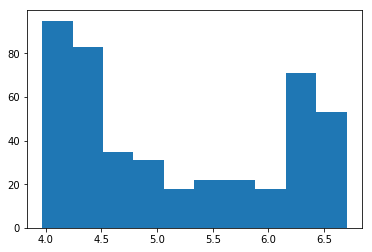

In [13]:
plt.hist(pear_array[0].ravel());

In [14]:
# RESHAPED PEAR ARRAY BELOW
pear_array_reshape = np.reshape(pear_array, (44, feature_h*feature_w*feature_c))
print(pear_array_reshape.shape)

(44, 448)


In [15]:
n_batch, n_mem = pear_array_reshape.shape
print(n_batch)
print(n_mem)

44
448


In [16]:
path = 'Data/TSMC_PCM_New_2_Clipped.pkl'
vs, mus, sigs, orig_min_Vs, orig_max_Vs, orig_min_Rs, orig_max_Rs = get_pcm_data(path, 
                                                                               n_mem, 
                                                                               norm_min=3.97, 
                                                                               norm_max=6.7)

In [17]:
# 20190814: NEED TO GET MIN AND MAX OF ARRAY FROM XIN IN ORDER TO DO THE PROPER NORMALIZATION 

In [18]:
# (n_p, n_mem)
print(vs.shape)
print(mus.shape)
print(sigs.shape)

(75, 448)
(75, 448)
(75, 448)


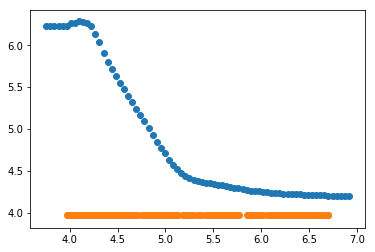

In [19]:
plt.scatter(vs[:,0], mus[:,0])
plt.scatter(pear_array_reshape[0], [3.97]*pear_array_reshape.shape[1])

In [20]:
interp_width = vs[1, 0] - vs[0, 0]

In [21]:
# 20190821: let's try drifting some test values from the array Xin sent (use 3.97 - 6.7)
#  - first create function to implement drift 

In [75]:
# NEXT: pull out v_gauss func and plot to see what this looks like (why are we not getting in negative values?)

In [33]:
def drift_Rs(Rs_array, t, vs, mus, sigs, interp_width, n_batch, n_mem):
    
#     eps = np.random.normal(size=n_batch*n_mem)
#     eps = np.reshape(eps, (n_batch, n_mem))
#     v_gauss = memristor_output(Rs_array, eps, vs, mus, sigs, interp_width)
    Rs_array_reshape = Rs_array.ravel()
    mu_gauss = 0.039*Rs_array_reshape-0.155
    sig_gauss = 0.018*Rs_array_reshape-0.075
    v_gauss = mu_gauss+sig_gauss*np.random.normal(size=len(Rs_array_reshape))
    # Rs_arryay has already gone through np.log10()
    return np.reshape(Rs_array_reshape+v_gauss*np.log10(t), (n_batch, n_mem))

In [57]:
def hours_to_secs(hours):
    return(hours*60*60)

In [78]:
num_hours = 12

In [71]:
R_drift = drift_Rs(pear_array_reshape, hours_to_secs(num_hours), vs, mus, sigs, interp_width, n_batch, n_mem)

In [72]:
# with tf.Session() as sess:
#     R_drift = sess.run(drift_Rs(pear_array_reshape, 2.0, vs, mus, sigs, interp_width, n_batch, n_mem))

In [73]:
R_drift.shape

(44, 448)

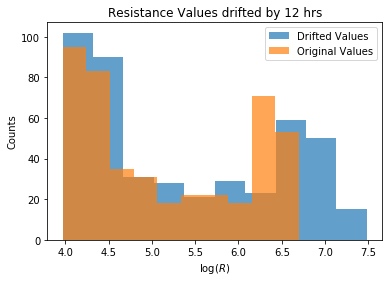

In [90]:
plt.hist(R_drift[0], label="Drifted Values", alpha=0.7);
plt.hist(pear_array_reshape[0], label="Original Values", alpha=0.7);
plt.title("Resistance Values drifted by {} hrs".format(num_hours))
plt.xlabel(r"$\log(R)$")
plt.ylabel("Counts")
plt.legend()

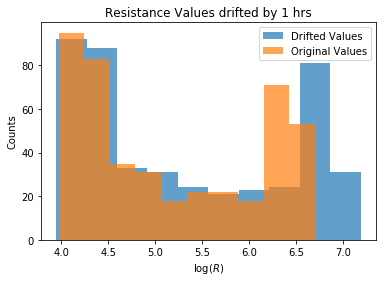

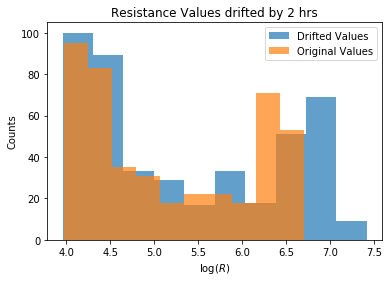

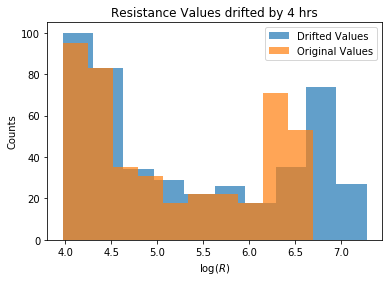

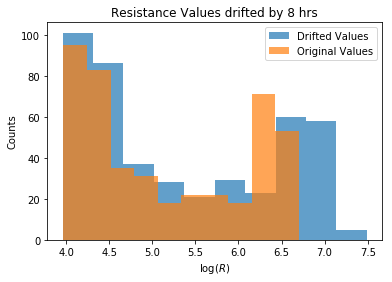

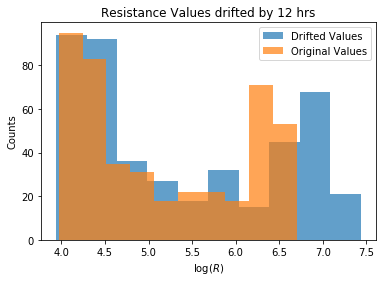

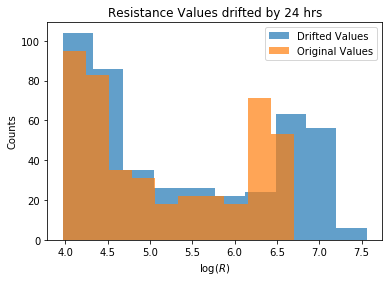

In [92]:
for i in [1, 2, 4, 8, 12, 24]:
    num_hours = i
    R_drift_new = drift_Rs(pear_array_reshape, hours_to_secs(num_hours), vs, mus, sigs, interp_width, n_batch, n_mem)
    plt.figure()
    plt.hist(R_drift_new[0], label="Drifted Values", alpha=0.7);
    plt.hist(pear_array_reshape[0], label="Original Values", alpha=0.7);
    plt.title("Resistance Values drifted by {} hrs".format(num_hours))
    plt.xlabel(r"$\log(R)$")
    plt.ylabel("Counts")
    plt.legend()
    plt.savefig("Drifting_Pear/Pear_Drift_Hist_20190903_{}_hrs.png".format(num_hours))

In [25]:
with tf.Session() as sess:
    interp_mus  = sess.run(gauss_interp(v, vs, mus, interp_width))
    interp_sigs = sess.run(gauss_interp(v, vs, sigs, interp_width))

In [26]:
interp_mus.shape

(3, 10)

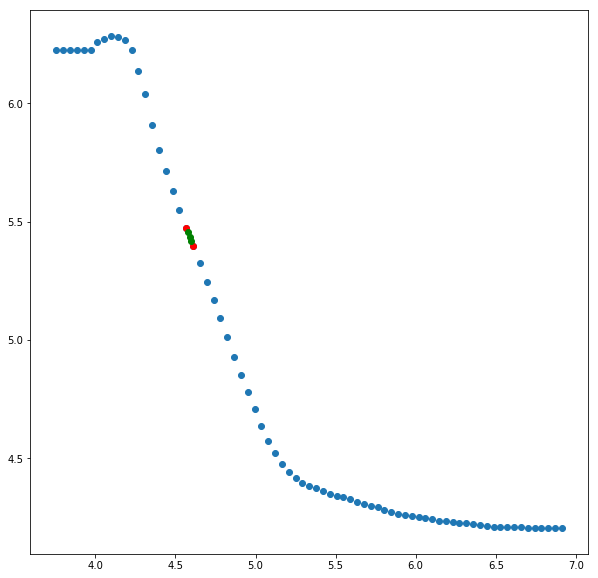

In [27]:
plt.figure(figsize = (10,10))
plt.scatter(vs[:, 0], mus[:,0])
plt.scatter(vs[19, 0], mus[19, 0], c="red")
plt.scatter(vs[20, 0], mus[20, 0], c="red")
plt.scatter(v[:,0], interp_mus[:, 0], c="green")

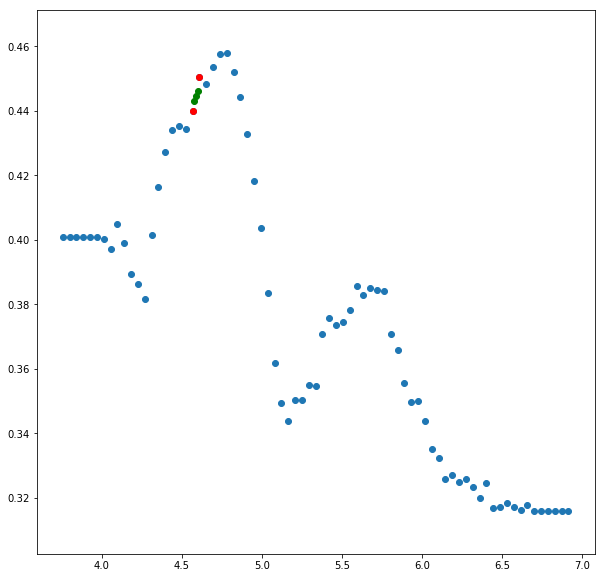

In [28]:
plt.figure(figsize = (10,10))
plt.scatter(vs[:, 0], sigs[:,0])
plt.scatter(vs[19, 0], sigs[19, 0], c="red")
plt.scatter(vs[20, 0], sigs[20, 0], c="red")
plt.scatter(v[:,0], interp_sigs[:, 0], c="green")